<center>
<h2><b><center>GENERATIVE AI</center></b></h2>
<h3><b>Assignment No. 1</b></h3>
<h4>22F-3863 &nbsp;&nbsp; Bushra Abad</h4>
<h4>22F-3324 &nbsp;&nbsp; Tayyaba Imtiaz</h4>
</center>


## 1. Environment setup

In [4]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")



CUDA available: True
GPU name: Tesla T4


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr30k") # Changed to dataset handle format

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'flickr30k' dataset.
Path to dataset files: /kaggle/input/flickr30k


In [6]:
import os
import pickle
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

# Use the 'path' variable from the previous cell which contains the dataset directory
# Let's inspect the contents of the downloaded path to ensure we use the correct image directory
print(f"Contents of the downloaded dataset directory ({path}): {os.listdir(path)}")

# Attempt to find the image directory
# Corrected: Use 'Images' instead of 'flickr30k_images'
possible_image_dir = os.path.join(path, 'Images')

if os.path.exists(possible_image_dir):
    IMAGE_DIR = possible_image_dir
    print(f"Found images at: {IMAGE_DIR}")
elif os.path.exists(path) and any(f.endswith(('.jpg', '.jpeg')) for f in os.listdir(path)):
    # If 'Images' subdirectory is not found, check if images are directly in the root path
    IMAGE_DIR = path
    print(f"Found images directly in: {IMAGE_DIR}")
elif os.path.exists('Images'):
    # Fallback to current directory if not found in cache (e.g., if path variable was cleared)
    IMAGE_DIR = 'Images'
    print(f"Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError("Could not find the Flickr30k image directory. Please ensure the dataset is downloaded and extracted correctly.")

OUTPUT_FILE = 'flickr30k_features.pkl'

Contents of the downloaded dataset directory (/kaggle/input/flickr30k): ['captions.txt', 'Images']
Found images at: /kaggle/input/flickr30k/Images


In [7]:
class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name

### 2. Load and Prepare Captions Data

First, we'll load the `captions.txt` file, which contains image filenames and their corresponding descriptive captions. We'll ensure the data is loaded correctly into a pandas DataFrame and then prepare the captions for further processing by cleaning and tokenizing the text.

In [8]:
import pandas as pd

caption_file = os.path.join(path, 'captions.txt') # Construct full path using the 'path' variable
df = pd.read_csv(caption_file, sep=',') # Corrected separator to comma
df = df[['image', 'caption']].rename(columns={'caption': 'comment'}) # Select 'image' and 'caption' and rename 'caption' to 'comment'
df['comment'] = df['comment'].str.strip()

print(f"Loaded {len(df)} caption entries.")
display(df.head())

Loaded 158915 caption entries.


,image,comment
0,1000092795.jpg,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,"Two young , White males are outside near many ..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


### 3. Preprocess Captions

To prepare the captions for our model, we'll perform several preprocessing steps:
1. Convert all text to lowercase.
2. Remove any characters that are not alphabetic (numbers, punctuation, special symbols).
3. Add a `<start>` token at the beginning and an `<end>` token at the end of each caption. These special tokens help the model understand the beginning and end of a sequence during training.

In [9]:
import re

def preprocess_caption(caption):
    # Ensure caption is a string, handle potential non-string values (e.g., NaN)
    caption = str(caption) # Convert to string to avoid AttributeError for non-string types
    caption = caption.lower() # Convert to lowercase
    caption = re.sub('[^a-z]', ' ', caption) # Remove non-alphabetic characters
    caption = re.sub('\s+', ' ', caption) # Replace multiple spaces with a single space
    caption = caption.strip() # Remove leading/trailing whitespace
    caption = '<start> ' + caption + ' <end>' # Add start and end tokens
    return caption

df['processed_comment'] = df['comment'].apply(preprocess_caption)

print("Captions preprocessing completed. Displaying first 5 processed captions:")
display(df.head())

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-957340750.py:8: SyntaxWarning: invalid escape sequence '\s'
  caption = re.sub('\s+', ' ', caption) # Replace multiple spaces with a single space


Captions preprocessing completed. Displaying first 5 processed captions:


,image,comment,processed_comment
0,1000092795.jpg,Two young guys with shaggy hair look at their ...,<start> two young guys with shaggy hair look a...
1,1000092795.jpg,"Two young , White males are outside near many ...",<start> two young white males are outside near...
2,1000092795.jpg,Two men in green shirts are standing in a yard .,<start> two men in green shirts are standing i...
3,1000092795.jpg,A man in a blue shirt standing in a garden .,<start> a man in a blue shirt standing in a ga...
4,1000092795.jpg,Two friends enjoy time spent together .,<start> two friends enjoy time spent together ...


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Initialize pre-trained ResNet50 model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1]) # Remove the last classification layer
model = nn.DataParallel(model).to(device)
model.eval() # Set model to evaluation mode

# Create dataset and data loader
dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2) # num_workers can be adjusted

features = {}

print("Extracting image features...")
with torch.no_grad(): # Disable gradient calculation for inference
    for imgs, names in tqdm(loader): # tqdm for progress bar
        imgs = imgs.to(device)
        feats = model(imgs).squeeze() # Extract features and remove singleton dimension
        for i, name in enumerate(names):
            features[name] = feats[i].cpu().numpy()

# Save the extracted features to a pickle file
with open(OUTPUT_FILE, "wb") as f:
    pickle.dump(features, f)

print(f"Feature extraction completed! Features saved to {OUTPUT_FILE}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 217MB/s]


Extracting image features...


100%|██████████| 249/249 [03:51<00:00,  1.07it/s]


Feature extraction completed! Features saved to flickr30k_features.pkl


In [11]:
import collections

# 1. Collect all processed captions
processed_captions = df['processed_comment'].tolist()

# 2. Tokenize each caption into individual words
tokenized_words = []
for caption in processed_captions:
    # Split the caption by space to get individual words
    # The preprocess_caption function already ensures single spaces
    tokenized_words.extend(caption.split())

# Count word frequencies (optional, but good for filtering rare words later)
word_counts = collections.Counter(tokenized_words)

# 3. Create a vocabulary by adding special tokens
# Ensure specific indices for special tokens
word2idx = {
    '<pad>': 0,
    '<start>': 1,
    '<end>': 2,
    '<unk>': 3
}

idx2word = {
    0: '<pad>',
    1: '<start>',
    2: '<end>',
    3: '<unk>'
}

# Starting index for new words
current_idx = len(word2idx)

# 4. Add all unique words from the tokenized captions to the vocabulary
# Filter out special tokens if they accidentally appeared in processed captions (though unlikely with current preprocessing)
# and add words that are not already in word2idx
for word, count in word_counts.items():
    # You might want to set a minimum frequency threshold here to reduce vocab size
    # For simplicity, we'll add all words for now.
    if word not in word2idx:
        word2idx[word] = current_idx
        idx2word[current_idx] = word
        current_idx += 1

# 6. Store the size of the vocabulary
vocab_size = len(word2idx)

print(f"Vocabulary created with {vocab_size} unique words.")
print("First 10 words in word2idx:", list(word2idx.items())[:10])
print("First 10 indices in idx2word:", list(idx2word.items())[:10])

Vocabulary created with 18083 unique words.
First 10 words in word2idx: [('<pad>', 0), ('<start>', 1), ('<end>', 2), ('<unk>', 3), ('two', 4), ('young', 5), ('guys', 6), ('with', 7), ('shaggy', 8), ('hair', 9)]
First 10 indices in idx2word: [(0, '<pad>'), (1, '<start>'), (2, '<end>'), (3, '<unk>'), (4, 'two'), (5, 'young'), (6, 'guys'), (7, 'with'), (8, 'shaggy'), (9, 'hair')]


In [12]:
import numpy as np

def caption_to_indices(caption_text, word2idx, max_len):
    indices = [word2idx['<start>']]

    words = caption_text.split()[1:-1] # Exclude the <start> and <end> tokens for index conversion

    for word in words:
        if word in word2idx:
            indices.append(word2idx[word])
        else:
            indices.append(word2idx['<unk>'])
    indices.append(word2idx['<end>'])

    # Pad or truncate the sequence
    if len(indices) < max_len:
        # Pad with <pad> token
        indices.extend([word2idx['<pad>']] * (max_len - len(indices)))
    elif len(indices) > max_len:
        # Truncate to max_len
        indices = indices[:max_len]

    return np.array(indices)
max_caption_length = max(len(cap.split()) for cap in df['processed_comment'])

print(f"Maximum caption length (including <start> and <end>): {max_caption_length}")


Maximum caption length (including <start> and <end>): 80


In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
import os

# Load pre-extracted image features
with open(OUTPUT_FILE, 'rb') as f:
    image_features = pickle.load(f)

image_to_captions = {}
for index, row in df.iterrows():
    img_name = row['image']
    processed_caption = row['processed_comment']
    if img_name not in image_to_captions:
        image_to_captions[img_name] = []
    image_to_captions[img_name].append(processed_caption)

class CaptionDataset(Dataset):
    def __init__(self, image_features, image_to_captions, word2idx, max_caption_length):
        self.image_features = image_features
        self.image_to_captions = image_to_captions
        self.word2idx = word2idx
        self.max_caption_length = max_caption_length

        # Get a list of unique image IDs available in the features and captions
        # This ensures we only use images for which we have both features and captions.
        self.image_ids = list(set(image_features.keys()) & set(image_to_captions.keys()))

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        # Get image features
        features = torch.tensor(self.image_features[image_id], dtype=torch.float32)

        # Get one random caption for the image (for training, we typically use one caption per image)
        captions_for_image = self.image_to_captions[image_id]
        # For simplicity, let's pick the first caption for now. A more robust approach might randomize or use all.
        selected_caption = captions_for_image[0]

        # Convert caption to indices and pad
        caption_indices = caption_to_indices(selected_caption, self.word2idx, self.max_caption_length)
        captions = torch.tensor(caption_indices, dtype=torch.long)

        return features, captions

print("CaptionDataset class defined and image features/captions loaded.")
print(f"Number of unique images with features and captions: {len(image_to_captions)}")


CaptionDataset class defined and image features/captions loaded.
Number of unique images with features and captions: 31783


In [14]:
from sklearn.model_selection import train_test_split

# Get all unique image IDs that have both features and captions
all_image_ids = list(set(image_features.keys()) & set(image_to_captions.keys()))

# Split the image IDs into training and validation sets
train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.2, random_state=42)

print(f"Total images: {len(all_image_ids)}")
print(f"Training images: {len(train_image_ids)}")
print(f"Validation images: {len(val_image_ids)}")

Total images: 31783
Training images: 25426
Validation images: 6357


In [15]:
import torch
from torch.utils.data import DataLoader

# Create CaptionDataset instances for training and validation
train_dataset = CaptionDataset(
    image_features={img_id: image_features[img_id] for img_id in train_image_ids},
    image_to_captions=image_to_captions,
    word2idx=word2idx,
    max_caption_length=max_caption_length
)

val_dataset = CaptionDataset(
    image_features={img_id: image_features[img_id] for img_id in val_image_ids},
    image_to_captions=image_to_captions,
    word2idx=word2idx,
    max_caption_length=max_caption_length
)

# Define DataLoader parameters
batch_size = 64 # This can be adjusted based on GPU memory
num_workers = 2 # This can be adjusted based on CPU cores

# Create DataLoader instances for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Training DataLoader created with {len(train_dataset)} samples and batch size {batch_size}.")
print(f"Validation DataLoader created with {len(val_dataset)} samples and batch size {batch_size}.")
print(f"First batch from train_loader: Features shape {next(iter(train_loader))[0].shape}, Captions shape {next(iter(train_loader))[1].shape}")


Training DataLoader created with 25426 samples and batch size 64.
Validation DataLoader created with 6357 samples and batch size 64.
First batch from train_loader: Features shape torch.Size([64, 2048]), Captions shape torch.Size([64, 80])


## Initialize Loss Function and Optimizer

### Subtask:
 `CrossEntropyLoss` as the loss function,  `ignore_index` is set to the ID of the padding token.  the `Adam` optimizer, passing the parameters of both the Encoder and Decoder models.


In [16]:
import torch.nn as nn
import torch
import torch.optim as optim
from torchvision import models

# EncoderCNN class definition (moved here to resolve NameError)
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # Define a linear layer to map the 2048-dimensional pre-extracted features
        # to the desired embed_size (which is the output dimension of the encoder)
        self.linear = nn.Linear(2048, embed_size)

        # Batch normalization for the output of the linear layer
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, features):
        # The input 'features' are already the 2048-dimensional pre-extracted features
        # Pass them through the linear layer and batch normalization
        features = self.bn(self.linear(features))
        return features

# Redefine DecoderRNN to support sequential prediction for greedy search
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size # Store hidden_size for state initialization
        self.num_layers = num_layers

    def forward(self, features, captions):
        # This forward pass is for training with teacher forcing (entire sequence at once)
        embeddings = self.embed(captions)

        # Initialize LSTM states with image features
        # Features are (batch_size, hidden_size), need to be (num_layers, batch_size, hidden_size)
        h0 = features.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c0 = torch.zeros_like(h0)

        lstm_output, _ = self.lstm(embeddings, (h0, c0))
        outputs = self.linear(lstm_output)
        return outputs

    def sample(self, features, max_caption_length, start_token_idx, end_token_idx):
        # This method is for inference (greedy search)
        sampled_ids = []

        # Initialize LSTM states with image features
        # Features are (batch_size=1, hidden_size), need to be (num_layers, batch_size=1, hidden_size)
        h = features.unsqueeze(0).repeat(self.num_layers, 1, 1) # (num_layers, 1, hidden_size)
        c = torch.zeros_like(h)

        # Start with <start> token
        input_word = torch.tensor([start_token_idx]).unsqueeze(0).to(features.device) # (1, 1)

        for _ in range(max_caption_length):
            embeddings = self.embed(input_word) # (1, 1, embed_size)

            # Pass the embedded word and current hidden/cell states to LSTM
            lstm_output, (h, c) = self.lstm(embeddings, (h, c)) # lstm_output: (1, 1, hidden_size)

            # Get predicted word scores
            outputs = self.linear(lstm_output.squeeze(1)) # outputs: (1, vocab_size)

            # Get the word with the highest probability
            predicted_word_idx = outputs.argmax(1)

            sampled_ids.append(predicted_word_idx.item())

            # If <end> token is predicted, break the loop
            if predicted_word_idx.item() == end_token_idx:
                break

            # Set the predicted word as the input for the next step
            input_word = predicted_word_idx.unsqueeze(0)

        return sampled_ids

print("DecoderRNN class redefined with a 'sample' method for greedy search.")

embed_size = 512
hidden_size = 1024
vocab_size = 18083 # Based on the notebook state 'vocab_size'
num_layers = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = EncoderCNN(hidden_size).to(device) # Note: EncoderCNN's input is 2048, output is hidden_size
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)

# Re-initialize optimizer with parameters of the newly defined models
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

print("Encoder and Decoder models re-initialized with the updated DecoderRNN and EncoderCNN definitions.")

DecoderRNN class redefined with a 'sample' method for greedy search.
Encoder and Decoder models re-initialized with the updated DecoderRNN and EncoderCNN definitions.


In [17]:
def greedy_search(image_features_vector, encoder, decoder, idx2word, max_caption_length, device, start_token_idx, end_token_idx):
    # Set models to evaluation mode
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        # Move image features to the device and reshape for encoder
        # Assuming image_features_vector is already a 1D numpy array or list representing a single image's features
        features = torch.tensor(image_features_vector, dtype=torch.float32).unsqueeze(0).to(device) # (1, 2048)

        # Pass features through the encoder
        encoded_features = encoder(features) # (1, hidden_size)

        # Use the decoder's sample method to generate the caption indices
        predicted_indices = decoder.sample(encoded_features, max_caption_length, start_token_idx, end_token_idx)

        # Convert indices to words
        predicted_caption_words = [idx2word[idx] for idx in predicted_indices]

    return predicted_caption_words

print("greedy_search function implemented.")


greedy_search function implemented.


## Implement Beam Search for Inference



In [18]:
import torch.nn.functional as F

def beam_search(image_features_vector, encoder, decoder, idx2word, max_caption_length, device, start_token_idx, end_token_idx, beam_width):
    # Set models to evaluation mode
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        encoded_features_tensor = torch.tensor(image_features_vector, dtype=torch.float32).unsqueeze(0).to(device) # (1, hidden_size)

        # Initialize beams
        # Each beam is a tuple: (score, sequence, h, c)
        # h and c need to be (num_layers, batch_size=1, hidden_size)
        initial_h = encoded_features_tensor.unsqueeze(0).repeat(decoder.num_layers, 1, 1) # (num_layers, 1, hidden_size)
        initial_c = torch.zeros_like(initial_h)

        beams = [
            (0.0, [start_token_idx], initial_h, initial_c) # (log_score, sequence, h_state, c_state)
        ]
        completed_beams = []

        for _ in range(max_caption_length):
            if not beams: # All active beams completed
                break

            candidates = []
            for current_score, current_sequence, current_h, current_c in beams:
                last_word_idx = current_sequence[-1]

                # If the last word is the end token, this beam is completed
                if last_word_idx == end_token_idx:
                    completed_beams.append((current_score, current_sequence, current_h, current_c))
                    continue

                # Embed the last word
                input_word = torch.tensor([last_word_idx]).unsqueeze(0).to(device) # (1, 1)
                embeddings = decoder.embed(input_word) # (1, 1, embed_size)

                # Pass through LSTM
                lstm_output, (next_h, next_c) = decoder.lstm(embeddings, (current_h, current_c))

                # Get predicted word scores
                output_logits = decoder.linear(lstm_output.squeeze(1)) # (1, vocab_size)

                # Convert to log probabilities
                log_probs = F.log_softmax(output_logits, dim=-1)

                # Get top 'beam_width' candidates
                top_log_probs, top_indices = log_probs.topk(beam_width)

                for j in range(top_indices.size(1)): # Iterate over top_indices for the current beam
                    log_prob = top_log_probs[0][j].item()
                    next_word = top_indices[0][j].item()
                    new_score = current_score + log_prob
                    new_sequence = current_sequence + [next_word]
                    candidates.append((new_score, new_sequence, next_h, next_c))

            # Sort all candidates by score and select top 'beam_width'
            candidates.sort(key=lambda x: x[0], reverse=True)
            beams = candidates[:beam_width] # Update beams for next iteration

        # After loop, all remaining beams are also considered complete (or max_length reached)
        completed_beams.extend(beams)

        # Select the best beam (highest score)
        if not completed_beams:
            # This case should ideally not happen if max_caption_length is sufficient
            # but as a fallback, return an empty caption or a default
            print("Warning: No completed beams found. Returning an empty caption.")
            return []

        best_beam = max(completed_beams, key=lambda x: x[0])
        predicted_indices = best_beam[1]

        # Convert indices to words
        predicted_caption_words = [idx2word[idx] for idx in predicted_indices]

        # Filter out special tokens for better readability
        clean_generated_caption = [
            word for word in predicted_caption_words
            if word not in ['<start>', '<end>', '<pad>', '<unk>']
        ]

    return clean_generated_caption

print("beam_search function implemented.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = EncoderCNN(hidden_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)

print("Encoder and Decoder models re-initialized for beam search (weights need to be loaded).")

beam_search function implemented.
Encoder and Decoder models re-initialized for beam search (weights need to be loaded).


In [19]:
!pip install gradio


In [20]:
import torch.nn as nn
from torchvision import models

# Initialize the ResNet50 feature extractor (same as used for pre-extraction)
resnet_feature_extractor = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet_feature_extractor = nn.Sequential(*list(resnet_feature_extractor.children())[:-1]) # Remove the last classification layer
resnet_feature_extractor = nn.DataParallel(resnet_feature_extractor).to(device)
resnet_feature_extractor.eval() # Set to evaluation mode

print("ResNet50 feature extractor initialized for Gradio app.")

ResNet50 feature extractor initialized for Gradio app.


In [21]:
def generate_caption_gradio(image):
    try:
        # 2. Preprocess the image
        image = image.convert('RGB')
        image_tensor = transform(image).unsqueeze(0) # Add batch dimension (1, 3, 224, 224)
        image_tensor = image_tensor.to(device)

        # Ensure models are in evaluation mode (important for inference)
        loaded_encoder.eval()
        loaded_decoder.eval()
        resnet_feature_extractor.eval() # Ensure the ResNet extractor is also in eval mode

        with torch.no_grad():
            # Step 1: Extract 2048-dim features using the ResNet50 feature extractor
            # Input to resnet_feature_extractor is (1, 3, 224, 224)
            # Output is (1, 2048) after squeeze
            resnet_features = resnet_feature_extractor(image_tensor).squeeze() # (2048,) or (1, 2048)

            # Ensure the features are (1, 2048) for the EncoderCNN if squeezed to 1D
            if resnet_features.ndim == 1:
                resnet_features = resnet_features.unsqueeze(0) # (1, 2048)

            # Step 2: Pass the 2048-dim features to the loaded_encoder (EncoderCNN)
            # The EncoderCNN will project these to hidden_size (e.g., 512)
            image_features_vector_encoded = loaded_encoder(resnet_features)

            # Convert to numpy for beam_search, which expects a 1D numpy array after this step
            # beam_search converts it back to tensor and unsqueezes, so (hidden_size,) is fine.
            image_features_vector_encoded_np = image_features_vector_encoded.squeeze().cpu().numpy()

            # 5. Generate a descriptive caption using beam_search
            generated_words = beam_search(
                image_features_vector_encoded_np, # Pass the encoded features from EncoderCNN
                loaded_encoder,
                loaded_decoder,
                idx2word,
                max_caption_length,
                device,
                start_token,
                end_token,
                beam_width
            )

        print(f"Raw generated words from beam_search: {generated_words}") # Diagnostic print

        # 6. Join the list of words into a single string
        if not generated_words:
            final_caption = "(No caption generated or all words were filtered out.)"
        else:
            final_caption = ' '.join(generated_words)

        # 7. Return the generated caption string
        return final_caption

    except Exception as e:
        error_message = f"An error occurred during caption generation: {e}"
        print(error_message) # Print to console for debugging
        return error_message

print("Function `generate_caption_gradio` defined (with debug logging and corrected feature extraction).")

Function `generate_caption_gradio` defined (with debug logging and corrected feature extraction).


In [22]:
import torch.nn as nn
import torch.optim as optim

# 1. Update hyperparameters
embed_size = 512 # Increased from 256
hidden_size = 1024 # Increased from 512
num_layers = 4 # Increased from 1
num_epochs = 20 # Increased from 5

# Get pad index from word2idx (already defined)
pad_idx = word2idx['<pad>']

# The criterion (loss function) remains the same unless vocab_size changes drastically or pad_idx changes.
# criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

# Ensure device is defined (it was already defined in previous cells)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Re-initialize Encoder with updated hidden_size (embed_size for EncoderCNN)
encoder = EncoderCNN(embed_size).to(device)

# 3. Re-initialize Decoder with updated embed_size, hidden_size, vocab_size, and num_layers
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)

# 4. Re-initialize the optimizer with combined parameters of the new Encoder and Decoder
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

print(f"Hyperparameters updated: embed_size={embed_size}, hidden_size={hidden_size}, num_layers={num_layers}, num_epochs={num_epochs}")
print("EncoderCNN, DecoderRNN models and Adam optimizer re-initialized with updated parameters.")

Hyperparameters updated: embed_size=512, hidden_size=1024, num_layers=4, num_epochs=20
EncoderCNN, DecoderRNN models and Adam optimizer re-initialized with updated parameters.


## Re-initialize Models and Optimizer

### Subtask:
After redefining EncoderCNN, re-initialize the `encoder` model using the new class definition. Also, re-initialize the `decoder` and `optimizer` to ensure they use the newly defined encoder and the updated hyperparameters (`embed_size`, `hidden_size`, `num_layers`).


In [23]:
import torch.nn as nn
import torch.optim as optim

# 1. Update hyperparameters
embed_size = 512 # Increased from 256
hidden_size = 1024 # Increased from 512
num_layers = 4# Increased from 1
num_epochs = 20 # Increased from 5

pad_idx = word2idx['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = EncoderCNN(hidden_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)

# 4. Re-initialize the optimizer with combined parameters of the new Encoder and Decoder
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

print(f"Hyperparameters updated: embed_size={embed_size}, hidden_size={hidden_size}, num_layers={num_layers}, num_epochs={num_epochs}")
print("EncoderCNN, DecoderRNN models and Adam optimizer re-initialized with updated parameters.")

Hyperparameters updated: embed_size=512, hidden_size=1024, num_layers=4, num_epochs=20
EncoderCNN, DecoderRNN models and Adam optimizer re-initialized with updated parameters.


In [24]:
num_epochs = 20 # Set the number of training epochs as per updated hyperparameters

# Keep track of losses (re-initialize for the new training run)
train_losses = []
val_losses = []

print("Starting training with updated hyperparameters...")

for epoch in range(num_epochs):
    # Set models to training mode
    encoder.train()
    decoder.train()
    total_train_loss = 0

    # Training loop
    for i, (features, captions) in enumerate(train_loader):
        # Move data to the device
        features = features.to(device)
        captions = captions.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        # Encode image features
        encoded_features = encoder(features)
        # Decode captions (input captions excluding the last token, as it's the target)
        # Target captions are captions excluding the first token (i.e., <start>)
        outputs = decoder(encoded_features, captions[:, :-1])

        # Calculate loss
        # Reshape outputs to (batch_size * sequence_length, vocab_size)
        # Reshape targets to (batch_size * sequence_length)
        loss = criterion(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # Print training loss periodically
        if (i + 1) % 100 == 0: # Print every 100 batches
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Train Loss: {avg_train_loss:.4f}")

    # Validation step
    encoder.eval() # Set encoder to evaluation mode
    decoder.eval() # Set decoder to evaluation mode
    total_val_loss = 0

    with torch.no_grad(): # Disable gradient calculation for validation
        for i, (features, captions) in enumerate(val_loader):
            features = features.to(device)
            captions = captions.to(device)

            encoded_features = encoder(features)
            outputs = decoder(encoded_features, captions[:, :-1])

            val_loss = criterion(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Validation Loss for Epoch [{epoch+1}/{num_epochs}]: {avg_val_loss:.4f}")

print("Training completed!")

Starting training with updated hyperparameters...
Epoch [1/20], Step [100/398], Train Loss: 5.6288
Epoch [1/20], Step [200/398], Train Loss: 5.3151
Epoch [1/20], Step [300/398], Train Loss: 4.8247
Epoch [1/20] completed. Average Train Loss: 5.2869
Validation Loss for Epoch [1/20]: 4.6136
Epoch [2/20], Step [100/398], Train Loss: 4.4201
Epoch [2/20], Step [200/398], Train Loss: 4.4737
Epoch [2/20], Step [300/398], Train Loss: 4.1598
Epoch [2/20] completed. Average Train Loss: 4.3122
Validation Loss for Epoch [2/20]: 4.1835
Epoch [3/20], Step [100/398], Train Loss: 3.9732
Epoch [3/20], Step [200/398], Train Loss: 3.9914
Epoch [3/20], Step [300/398], Train Loss: 3.7965
Epoch [3/20] completed. Average Train Loss: 3.9054
Validation Loss for Epoch [3/20]: 3.9563
Epoch [4/20], Step [100/398], Train Loss: 3.5620
Epoch [4/20], Step [200/398], Train Loss: 3.7935
Epoch [4/20], Step [300/398], Train Loss: 3.6353
Epoch [4/20] completed. Average Train Loss: 3.6447
Validation Loss for Epoch [4/20]: 3

In [25]:
import torch

# Save the state dictionaries of the newly trained models
torch.save(encoder.state_dict(), 'encoder_model.pth')
torch.save(decoder.state_dict(), 'decoder_model.pth')

print("Newly trained encoder and decoder models saved successfully.")

Newly trained encoder and decoder models saved successfully.


In [26]:
import torch

# Ensure models are on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-initialize new instances of EncoderCNN and DecoderRNN with same hyperparameters
# These values should match the ones used for the recent training
# embed_size, hidden_size, vocab_size, num_layers are already defined globally

# Create new instances of the models (to ensure weights are loaded cleanly)
# NOTE: EncoderCNN's parameter should be hidden_size for proper matching with DecoderRNN's LSTM
loaded_encoder = EncoderCNN(hidden_size).to(device)
loaded_decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)

# Load the saved state dictionaries
loaded_encoder.load_state_dict(torch.load('encoder_model.pth'))
loaded_decoder.load_state_dict(torch.load('decoder_model.pth'))

# Ensure both encoder and decoder are set to evaluation mode
loaded_encoder.eval()
loaded_decoder.eval()

# Define beam_width (re-using previous value)
beam_width = 3

print("Newly trained models reloaded and set to evaluation mode for Gradio.")
print(f"Beam width set to {beam_width}.")

Newly trained models reloaded and set to evaluation mode for Gradio.
Beam width set to 3.


In [27]:
all_generated_captions = []
all_reference_captions = []

print("Cleared previous generated and reference captions lists.")

Cleared previous generated and reference captions lists.


In [28]:
import tqdm
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize # Though not explicitly used for tokenizing, good practice for text processing
import numpy as np

# A smoothing function for BLEU score to prevent zero scores when no matches
chencherry = SmoothingFunction()

def calculate_bleu_score(reference_captions, generated_caption):
    """
    Calculates the BLEU-4 score for a single generated caption against multiple references.

    Args:
        reference_captions (list of lists of str): List of tokenized reference captions.
        generated_caption (list of str): Tokenized generated caption.

    Returns:
        float: BLEU-4 score.
    """
    # NLTK sentence_bleu expects a list of reference sentences (each a list of words)
    # and a single hypothesis sentence (a list of words).
    return sentence_bleu(reference_captions, generated_caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method1)

def calculate_precision_recall_f1(reference_captions, generated_caption):
    """
    Calculates Precision, Recall, and F1-score for a single generated caption
    against multiple references, choosing the best match among references.

    Args:
        reference_captions (list of lists of str): List of tokenized reference captions.
        generated_caption (list of str): Tokenized generated caption.

    Returns:
        tuple: (precision, recall, f1_score)
    """
    # Convert generated caption to a set for efficient word lookup
    generated_set = set(generated_caption)
    len_generated = len(generated_caption)

    best_precision = 0.0
    best_recall = 0.0
    best_f1 = 0.0

    if len_generated == 0: # Avoid division by zero if generated caption is empty
        return 0.0, 0.0, 0.0

    for ref_cap_words in reference_captions:
        ref_set = set(ref_cap_words)
        len_ref = len(ref_cap_words)

        common_words = generated_set.intersection(ref_set)
        num_common = len(common_words)

        # Precision for this reference
        precision = num_common / len_generated

        # Recall for this reference
        recall = num_common / len_ref if len_ref > 0 else 0.0

        # F1-score for this reference
        if precision + recall > 0:
            f1 = (2 * precision * recall) / (precision + recall)
        else:
            f1 = 0.0

        # Keep the best scores
        if f1 > best_f1: # Prioritize F1 for "best match"
            best_f1 = f1
            best_precision = precision
            best_recall = recall

    return best_precision, best_recall, best_f1


start_token = word2idx['<start>']
end_token = word2idx['<end>']

# Ensure models are in evaluation mode
loaded_encoder.eval()
loaded_decoder.eval()

# Lists to store scores for all validation images (re-initialize for this run)
bleu_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate through the validation dataset to collect generated and reference captions
for image_id in tqdm.tqdm(val_image_ids, desc="Collecting captions and calculating metrics"): # Using tqdm for progress bar
    # Get image features
    sample_image_feature = image_features[image_id]

    with torch.no_grad():
        raw_feature_tensor = torch.tensor(sample_image_feature, dtype=torch.float32).unsqueeze(0).to(device)
        encoded_feature_for_beam = loaded_encoder(raw_feature_tensor).squeeze().cpu().numpy()

    generated_caption_words = beam_search(
        encoded_feature_for_beam,
        loaded_encoder,
        loaded_decoder,
        idx2word,
        max_caption_length,
        device,
        start_token,
        end_token,
        beam_width
    )

    # Store the generated caption
    all_generated_captions.append(generated_caption_words)

    # Get all ground truth captions for the current image
    ground_truth_captions = image_to_captions[image_id]

    # Process ground truth captions: tokenize and remove special tokens
    processed_references = []
    for caption_text in ground_truth_captions:
        clean_caption_words = [word for word in caption_text.replace('<start>', '').replace('<end>', '').strip().split() if word not in ['<pad>', '<unk>']]
        processed_references.append(clean_caption_words)

    # Store all reference captions for this image
    all_reference_captions.append(processed_references)

    # Calculate metrics for the current image
    bleu = calculate_bleu_score(processed_references, generated_caption_words)
    prec, rec, f1 = calculate_precision_recall_f1(processed_references, generated_caption_words)

    bleu_scores.append(bleu)
    precision_scores.append(prec)
    recall_scores.append(rec)
    f1_scores.append(f1)

# Calculate average scores

avg_bleu = np.mean(bleu_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

print(f"\n--- Quantitative Metrics on Validation Set (Newly Trained Model) ---")
print(f"Average BLEU-4 Score: {avg_bleu:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")


--- Quantitative Metrics on Validation Set (Newly Trained Model) ---
Average BLEU-4 Score: 0.1002
Average Precision: 0.2981
Average Recall: 0.3780
Average F1-score: 0.3219


# Task
Plot the training and validation loss curves from the most recent training run to visualize the learning progress with the updated hyperparameters.

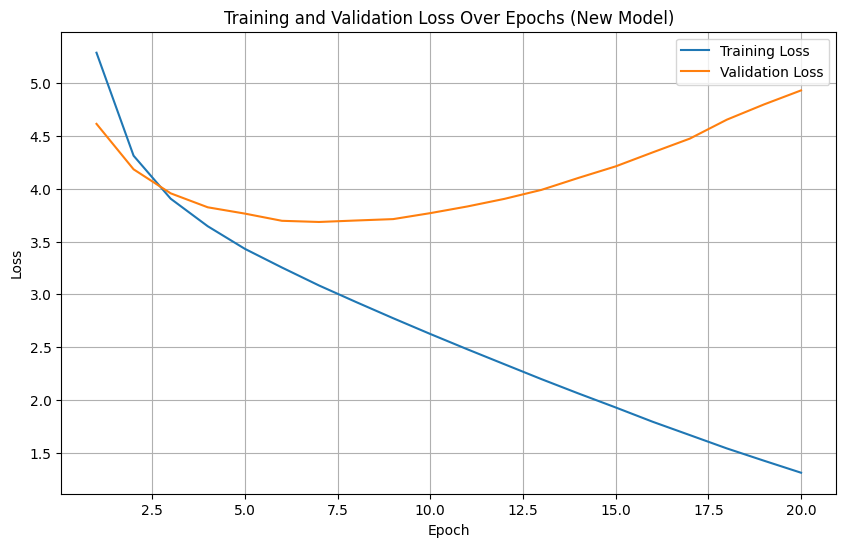

In [30]:
import matplotlib.pyplot as plt

# Create a list of epochs for the x-axis
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs (New Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Generating captions for 5 random images from the validation set.

--- Image 1/5: 3431636707.jpg ---


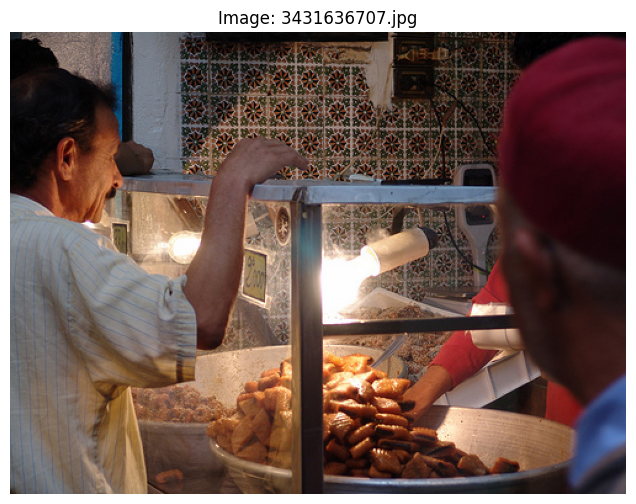

Ground Truth Captions:
  1. a man in a blue pin striped shirt waiting for his food that he has ordered
  2. a man is watching a restaurant worker prepare raviolis in a metal dish
  3. a man in a white shirts waits for a person to prepare the food
  4. a man standing in front of a counter looking a prepared food
  5. an old customer waits for his food from a vendor
Generated Caption (Beam Search, Beam Width=3): a man in a white shirt and a white apron is in front of a barbecue grill

--- Image 2/5: 1470536919.jpg ---


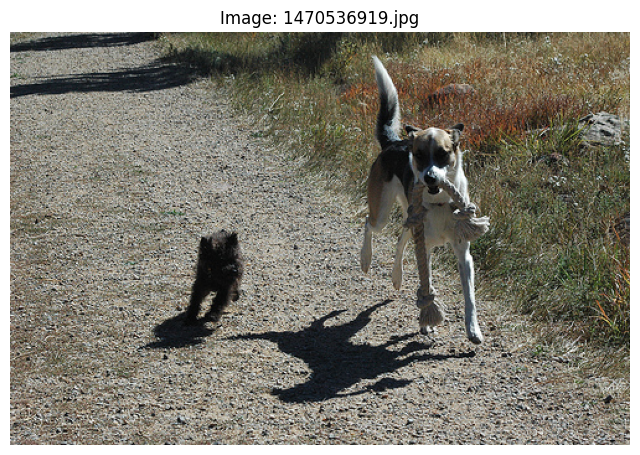

Ground Truth Captions:
  1. a small black dog is running along side a bigger tri colored dog that is carrying a rope toy in its mouth
  2. a little black dog is running beside a large brown and white dog with a large rope in its mouth
  3. the large dog is holding a rope in its mouth and the little dog is walking beside it
  4. a small dog and a large dog with a rope in its mouth
  5. two dogs running down a dirt road
Generated Caption (Beam Search, Beam Width=3): two dogs are running in a field

--- Image 3/5: 2383471951.jpg ---


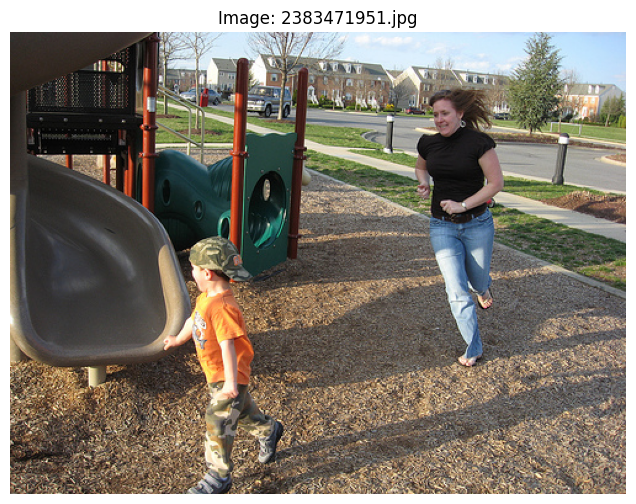

Ground Truth Captions:
  1. a woman with a black top blue jeans and sandals chasing a child with an orange shirt tennis shoes and camouflaged hat and pants at the playground
  2. a woman in a black shirt is chasing a young child around a playground
  3. a woman in a black shirt chases a little boy in an orange shirt
  4. woman chasing child dressed in orange shirt at a playground
  5. a woman chases a child in a playground
Generated Caption (Beam Search, Beam Width=3): three boys with helmets ride down a road clearing that could be two other children play nearby

--- Image 4/5: 3474985008.jpg ---


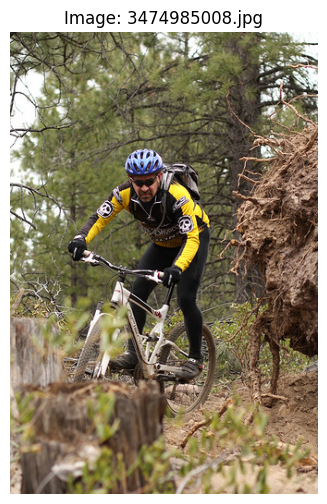

Ground Truth Captions:
  1. a man with a blue helmet and a yellow and black jacket is riding a bike in the woods
  2. a man in a blue helmet and sunglasses bikes through wooded terrain
  3. a man rides his bicycle through some grass in a wooded area
  4. a man in a blue helmet rides a mountain bike
  5. a mountain biker riding through the woods
Generated Caption (Beam Search, Beam Width=3): a man is riding a bike in the woods with his legs outwards

--- Image 5/5: 2479553749.jpg ---


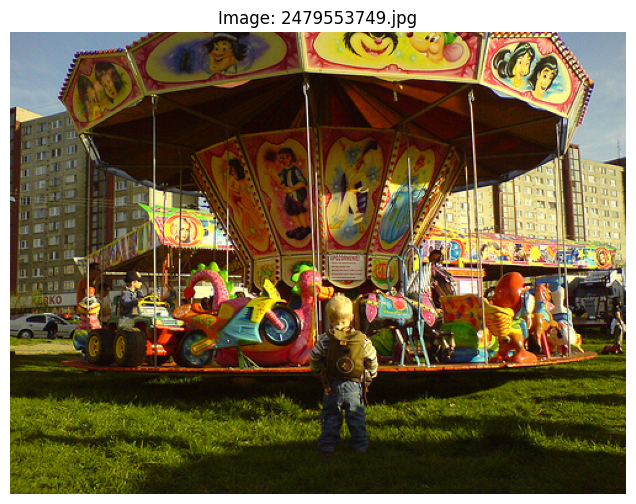

Ground Truth Captions:
  1. small child looking at a colorful children s amuseument ride
  2. a tow headed boy looks on at the children s merry go round
  3. a little baby standing in front of a colorful merry go round
  4. a little boy watches a ferris wheel in motion
  5. a little boy is watching a merry go round
Generated Caption (Beam Search, Beam Width=3): a group of people are sitting in chairs in the grass with a carousel in the background


In [31]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# 7. Select 5 unique random image IDs from val_image_ids
selected_image_ids = random.sample(val_image_ids, 5)

print(f"Generating captions for {len(selected_image_ids)} random images from the validation set.")

# Define start and end token indices
start_token = word2idx['<start>']
end_token = word2idx['<end>']

# 8. Loop through these 5 selected image IDs
for i, image_id in enumerate(selected_image_ids):
    print(f"\n--- Image {i+1}/{len(selected_image_ids)}: {image_id} ---")

    # a. Construct the full path to the image file
    image_path = os.path.join(IMAGE_DIR, image_id)

    # b. Load and display the image
    try:
        img = Image.open(image_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"Image: {image_id}")
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}. Skipping.")
        continue

    # c. Retrieve and print all ground truth captions
    ground_truth_captions = image_to_captions[image_id]
    print("Ground Truth Captions:")
    for j, caption in enumerate(ground_truth_captions):
        # Clean up special tokens for display
        clean_caption = caption.replace('<start>', '').replace('<end>', '').strip()
        print(f"  {j+1}. {clean_caption}")

    # d. Retrieve the pre-extracted image feature vector
    sample_image_feature = image_features[image_id]

    # e. Generate a caption using the beam_search function
    # First, encode the raw feature using the loaded encoder
    with torch.no_grad():
        raw_feature_tensor = torch.tensor(sample_image_feature, dtype=torch.float32).unsqueeze(0).to(device)
        encoded_feature_for_beam = loaded_encoder(raw_feature_tensor).squeeze().cpu().numpy()

    generated_caption_words = beam_search(
        encoded_feature_for_beam,
        loaded_encoder, # Use loaded models
        loaded_decoder, # Use loaded models
        idx2word,
        max_caption_length,
        device,
        start_token,
        end_token,
        beam_width
    )

    # f. Print the generated caption
    print(f"Generated Caption (Beam Search, Beam Width={beam_width}): {' '.join(generated_caption_words)}")

In [32]:
import gradio as gr

with gr.Blocks(title='Image Captioning Model (Custom Layout)') as demo:
    gr.Markdown(
    """
    # Image Captioning Model
    Upload an image and the model will generate a descriptive caption using beam search.
    """
    )
    with gr.Row():
        with gr.Column():
            image_input = gr.Image(type='pil', label='Upload Image')
            generate_button = gr.Button('Generate Caption')
        with gr.Column():
            caption_output = gr.Textbox(label='Generated Caption', lines=3)

    generate_button.click(
        fn=generate_caption_gradio,
        inputs=image_input,
        outputs=caption_output
    )

print('Launching Gradio interface with custom layout and updated model...')
demo.launch(share=True)

Launching Gradio interface with custom layout and updated model...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bf6e9db97b31a7e098.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
